# Emotional numbing in PTSD a look into a paradox

PTSD is famously known among other for hyper arousal, anger, nightmare, problems with emotion regulation and emotional numbing. </br>
While most symptoms point to over expression of emotions, emotional numbing states that there is low emotionality.

In a not realy direct way, here, we will continue to explore the idea we proposed in the SIA paper.</br>
Mainly, reduced response to low valance/arousing stimuli and high response to higher valance stimuli.

In this experiment we will explore this by asking people with or without diagnosis of PTSD to rate pictures from known datasets (IAPS/NAPS).</br> 
Using the dataset reported valence rating as the X axis and participants rating as the y-axis, we will fit a 5 parameter logistic regression to the curve of participants and compare the parameters between the groups.

The formula we will use for the 5PL regression:

y = d + (a-d)/(1+(x/c)^b)^g

a theoretical response at min</br>
b slope factor</br>
c mid range </br>
d theoretical response at max</br>
g asymmetrical factor</br>

Our main hypothesis is regadind b.</br>
Lower values of b point to a linear relation.</br>
Our main hypothesis is a larger b in the PTSD group compared with control.</br>
Secondary hypothesis include:</br>
1. b will be modulated by emotional numbing (PCL5)</br>
2. d will be modulated by depression/anhedonia score (PCL5/BDI)

In [1]:
import pandas as pd
import numpy as np
import numpyro

import pymc as pm
import arviz as az
import jax

import matplotlib.pyplot as ply
import seaborn as sns

/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Data generation

If we assume that participants with or without PTSD diagnosis both respond using a 5PL model,</br>
only the PTSD group has a higher b value.

This assumption is possible if we consider that variance of items in the IAPS tend to be smaller toward the edges.

IAPS/NAPS ratings are 1-9, with 1 most negative, 5 neutral and 9 most positive.</br>
For ease of analysis we will use rating -1 (i.e., 0-4).</br>
Our participants will use a scale of 1-100(/100).

In [2]:
def add_sub(trials = 100, min_r = 0, max_r = 4, noise = .1, slope=10):
    
    x = np.arange(min_r, max_r, max_r/trials)
    a = np.random.beta(1, 20, 1)[0] # close to 0 but not 0.
    b = np.random.normal(slope, 2, 1)[0] # this is where the magic happens
    c = np.random.normal(2.5, .5, 1)[0] # kind of average
    d = np.random.beta(10, 10, 1)[0] # close to 0.5
    g = np.random.normal(1, .2, 1)[0] # almost symetrical
    
    # the 5PL formula
    y = d + (a-d)/(1+(x/c)**b)**g + np.random.normal(0, noise, trials)
    
    # replace negative values with 0 (you cannot rate lower than 0)
    y = [0 if i < 0 else i for i in y]   

    df = pd.DataFrame({'x': x, 'y': y})
    return(df)

Let's see if we can find a difference of 2 in 100 subs

In [3]:
n_subs = 50
slope_ptsd = 10
slope_control = 8
ptsd_df = pd.DataFrame()
cont_df = pd.DataFrame()
for i in range(n_subs):
    
    temp_p = add_sub(slope = slope_ptsd)
    temp_c = add_sub(slope = slope_control)
    temp_p['sub'] = i
    temp_c['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    cont_df = pd.concat([cont_df, temp_c])
    
sub_idxP = list(ptsd_df['sub'])
sub_idxC = list(cont_df['sub'])

In [4]:
with pm.Model() as five_PL:
    
    # hyper prior per group
    b = pm.Normal('b', 6, 3, shape=2)
    
    aC = pm.Beta('aC',   1,   20,  shape = n_subs)
    bC = pm.Normal('bC', b[0], 2,  shape = n_subs)
    cC = pm.Normal('cC', 2.5, .5,  shape = n_subs)
    dC = pm.Beta('dC',   10,  10,  shape = n_subs)
    gC = pm.Normal('gC', 1,   .2,  shape = n_subs)
    
    aP = pm.Beta('aP',   1,   20,  shape = n_subs)
    bP = pm.Normal('bP', b[1], 2,  shape = n_subs)
    cP = pm.Normal('cP', 2.5, .5,  shape = n_subs)
    dP = pm.Beta('dP',   10,  10,  shape = n_subs)
    gP = pm.Normal('gP', 1,   .2,  shape = n_subs)
    
    
    eps = pm.Exponential('eps', 1, shape=2)
    
    y_hatC = dC[sub_idxC] + (aC[sub_idxC]-dC[sub_idxC])/(1+(cont_df['x'].values/cC[sub_idxC])**bC[sub_idxC])**gC[sub_idxC]
    y_hatP = dP[sub_idxP] + (aP[sub_idxP]-dP[sub_idxP])/(1+(ptsd_df['x'].values/cP[sub_idxP])**bP[sub_idxP])**gP[sub_idxP]

    # Likelihood (sampling distribution) of observations
    ratingC = pm.Normal('ratingC',y_hatC, eps[0], observed=cont_df.y)
    ratingP = pm.Normal('ratingP',y_hatP, eps[1], observed=ptsd_df.y)

    trace_PL5 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

ERROR:pymc:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


How well have this model preform?

<AxesSubplot:ylabel='Count'>

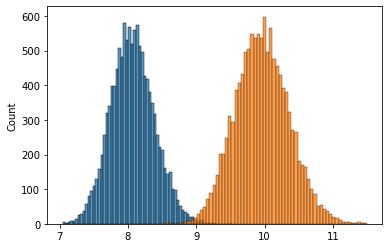

In [5]:
tr = trace_PL5.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.bC[:,:].values, axis = 0)
PTSD    = np.mean(tr.bP[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

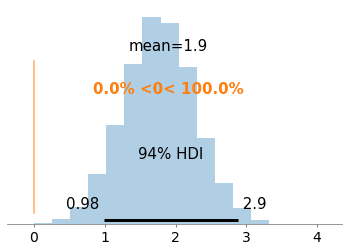

In [6]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

The model overshoots a bit, but within the HDI.</br>
Let's look at the fit

<AxesSubplot:xlabel='x', ylabel='y'>

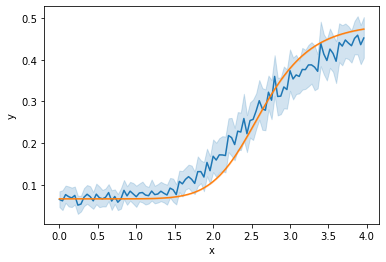

In [7]:
a5 = az.summary(trace_PL5, var_names=['aC'])[['mean']]
b5 = az.summary(trace_PL5, var_names=['bC'])[['mean']]
c5 = az.summary(trace_PL5, var_names=['cC'])[['mean']]
d5 = az.summary(trace_PL5, var_names=['dC'])[['mean']]
g5 = az.summary(trace_PL5, var_names=['gC'])[['mean']]

df_C = pd.DataFrame({'a': np.mean(a5['mean']),
                     'b': np.mean(b5['mean']),
                     'c': np.mean(c5['mean']),
                     'd': np.mean(d5['mean']),
                     'g': np.mean(g5['mean']),
                     'x': cont_df.x})

df_C['y'] = df_C.d + (df_C.a-df_C.d)/(1+(df_C.x/df_C.c)**df_C.b)**df_C.g


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=df_C)

<AxesSubplot:xlabel='x', ylabel='y'>

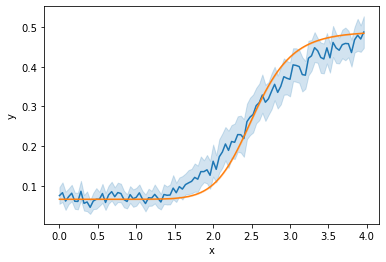

In [8]:
a5 = az.summary(trace_PL5, var_names=['aP'])[['mean']]
b5 = az.summary(trace_PL5, var_names=['bP'])[['mean']]
c5 = az.summary(trace_PL5, var_names=['cP'])[['mean']]
d5 = az.summary(trace_PL5, var_names=['dP'])[['mean']]
g5 = az.summary(trace_PL5, var_names=['gP'])[['mean']]

df_P = pd.DataFrame({'a': np.mean(a5['mean']),
                     'b': np.mean(b5['mean']),
                     'c': np.mean(c5['mean']),
                     'd': np.mean(d5['mean']),
                     'g': np.mean(g5['mean']),
                     'x': ptsd_df.x})

df_P['y'] = df_P.d + (df_P.a-df_P.d)/(1+(df_P.x/df_P.c)**df_P.b)**df_P.g

sns.lineplot(x='x',y='y',data=ptsd_df)
sns.lineplot(x='x',y='y',data=df_P)

Compare model to a linear model

In [9]:
with pm.Model() as linear:
    
    b_h = pm.Normal('b_h', 1, 1, shape=2)
   
    aC = pm.Normal('interceptC', 0, 5, shape = n_subs)
    bC = pm.Normal('slopeC', b_h[1], 1, shape = n_subs)
   
    aP = pm.Normal('interceptP', 0, 5, shape = n_subs)
    bP = pm.Normal('slopeP', b_h[0], 1, shape = n_subs)
    
    eps = pm.Exponential('eps', 1, shape=2)

    y_hatC = aC[sub_idxC] + bC[sub_idxC] * cont_df.x
    y_hatP = aP[sub_idxP] + bP[sub_idxP] * ptsd_df.x

       
    # Likelihood (sampling distribution) of observations
    ratingC = pm.Normal('ratingC',y_hatC, eps[0], observed=cont_df.y)
    ratingP = pm.Normal('ratingP',y_hatP, eps[1], observed=ptsd_df.y)

    
    trace_linear = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

In [10]:
az.loo(trace_PL5, var_name="ratingP")

Computed from 12000 posterior samples and 5000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  5012.99    55.06
p_loo      179.04        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     5000  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [11]:
az.loo(trace_linear, var_name="ratingP")

Computed from 12000 posterior samples and 5000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  3802.78    48.06
p_loo       99.91        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     5000  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

The model fit looks very good.
To test for sensitivity let's try only 30 trials

In [12]:
n_subs = 100
slope_ptsd = 10
slope_control = 8
ptsd_df = pd.DataFrame()
cont_df = pd.DataFrame()
for i in range(n_subs):
    
    temp_p = add_sub(slope = slope_ptsd, trials = 30)
    temp_c = add_sub(slope = slope_control, trials = 30)
    temp_p['sub'] = i
    temp_c['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    cont_df = pd.concat([cont_df, temp_c])
    
sub_idxP = list(ptsd_df['sub'])
sub_idxC = list(cont_df['sub'])

In [13]:
with pm.Model() as five_PL:
    
    # hyper prior per group
    b = pm.Normal('b', 6, 4, shape=2)
    
    aC = pm.Beta('aC',   1,   20,  shape = n_subs)
    bC = pm.Normal('bC', b[0], 2,  shape = n_subs)
    cC = pm.Normal('cC', 2.5, .5,  shape = n_subs)
    dC = pm.Beta('dC',   10,  10,  shape = n_subs)
    gC = pm.Normal('gC', 1,   .2,  shape = n_subs)
    
    aP = pm.Beta('aP',   1,   20,  shape = n_subs)
    bP = pm.Normal('bP', b[1], 2,  shape = n_subs)
    cP = pm.Normal('cP', 2.5, .5,  shape = n_subs)
    dP = pm.Beta('dP',   10,  10,  shape = n_subs)
    gP = pm.Normal('gP', 1,   .2,  shape = n_subs)
    
    
    eps = pm.Exponential('eps', 1, shape=2)
    
    y_hatC = dC[sub_idxC] + (aC[sub_idxC]-dC[sub_idxC])/(1+(cont_df['x'].values/cC[sub_idxC])**bC[sub_idxC])**gC[sub_idxC]
    y_hatP = dP[sub_idxP] + (aP[sub_idxP]-dP[sub_idxP])/(1+(ptsd_df['x'].values/cP[sub_idxP])**bP[sub_idxP])**gP[sub_idxP]

    # Likelihood (sampling distribution) of observations
    ratingC = pm.Normal('ratingC',y_hatC, eps[0], observed=cont_df.y)
    ratingP = pm.Normal('ratingP',y_hatP, eps[1], observed=ptsd_df.y)

    trace_PL5_30 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

ERROR:pymc:There were 243 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 188 divergences after tuning. Increase `target_accept` or reparameterize.


<AxesSubplot:ylabel='Count'>

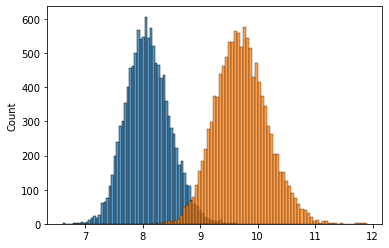

In [14]:
tr = trace_PL5_30.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.bC[:,:].values, axis = 0)
PTSD    = np.mean(tr.bP[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

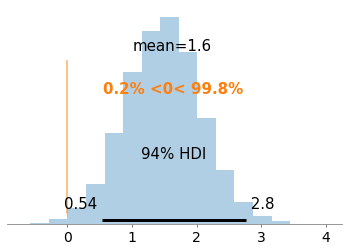

In [15]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

Uneven data set?

In [16]:
n_subs_p = 50
n_subs_c = 450
slope_ptsd = 10
slope_control = 8
ptsd_df = pd.DataFrame()
cont_df = pd.DataFrame()
for i in range(n_subs_p):
    
    temp_p = add_sub(slope = slope_ptsd, trials = 40)
    temp_p['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])

for i in range(n_subs_c):
    
    temp_c = add_sub(slope = slope_control, trials = 40)
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    
sub_idxP = list(ptsd_df['sub'])
sub_idxC = list(cont_df['sub'])

In [17]:
with pm.Model() as five_PL:
    
    # hyper prior per group
    b = pm.Normal('b', 6, 4, shape=2)
    
    aC = pm.Beta('aC',   1,   20,  shape = n_subs_c)
    bC = pm.Normal('bC', b[0], 2,  shape = n_subs_c)
    cC = pm.Normal('cC', 2.5, .5,  shape = n_subs_c)
    dC = pm.Beta('dC',   10,  10,  shape = n_subs_c)
    gC = pm.Normal('gC', 1,   .2,  shape = n_subs_c)
    
    aP = pm.Beta('aP',   1,   20,  shape = n_subs_p)
    bP = pm.Normal('bP', b[1], 2,  shape = n_subs_p)
    cP = pm.Normal('cP', 2.5, .5,  shape = n_subs_p)
    dP = pm.Beta('dP',   10,  10,  shape = n_subs_p)
    gP = pm.Normal('gP', 1,   .2,  shape = n_subs_p)
    
    
    eps = pm.Exponential('eps', 1, shape=2)
    
    y_hatC = dC[sub_idxC] + (aC[sub_idxC]-dC[sub_idxC])/(1+(cont_df['x'].values/cC[sub_idxC])**bC[sub_idxC])**gC[sub_idxC]
    y_hatP = dP[sub_idxP] + (aP[sub_idxP]-dP[sub_idxP])/(1+(ptsd_df['x'].values/cP[sub_idxP])**bP[sub_idxP])**gP[sub_idxP]

    # Likelihood (sampling distribution) of observations
    ratingC = pm.Normal('ratingC',y_hatC, eps[0], observed=cont_df.y)
    ratingP = pm.Normal('ratingP',y_hatP, eps[1], observed=ptsd_df.y)

    trace_PL5_uneven = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

ERROR:pymc:There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 48 divergences after tuning. Increase `target_accept` or reparameterize.


<AxesSubplot:ylabel='Count'>

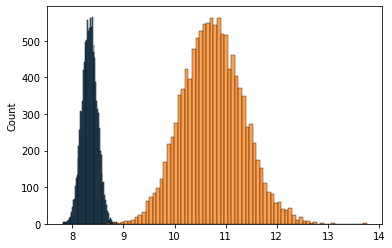

In [18]:
tr = trace_PL5_uneven.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.bC[:,:].values, axis = 0)
PTSD    = np.mean(tr.bP[:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)

Text(0.5, 1.0, '')

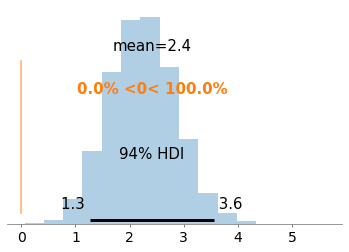

In [19]:
Group = PTSD - Control
az.plot_posterior(Group, point_estimate='mean', kind='hist', ref_val=0).set_title("")

just in case normal participants respond linearly. let's see if the model can find that

In [20]:
def add_sub_lin(trials = 100, min_r = 0, max_r = 4, noise = .1):
    
    x = np.arange(min_r, max_r, max_r/trials)

    y = 1/8 * x + np.random.normal(0, noise, trials)
    
    # replace negative values with 0 (you cannot rate lower than 0)
    y = [0 if i < 0 else i for i in y]   

    df = pd.DataFrame({'x': x, 'y': y})
    return(df)

In [24]:
n_subs_c = 450
cont_df = pd.DataFrame()

for i in range(n_subs_c):
    
    temp_c = add_sub_lin(trials = 40, noise = .2)
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    
sub_idxC = list(cont_df['sub'])

In [25]:
with pm.Model() as five_PL:
    
    # hyper prior per group
    b = pm.Normal('b', 6, 4)
    
    aC = pm.Beta('aC',   1,   20,  shape = n_subs_c)
    bC = pm.Normal('bC', b,    3,  shape = n_subs_c)
    cC = pm.Normal('cC', 2.5, .5,  shape = n_subs_c)
    dC = pm.Beta('dC',   10,  10,  shape = n_subs_c)
    gC = pm.Normal('gC', 1,   .2,  shape = n_subs_c)
    
    eps = pm.Exponential('eps', 1)
    
    y_hatC = dC[sub_idxC] + (aC[sub_idxC]-dC[sub_idxC])/(1+(cont_df['x'].values/cC[sub_idxC])**bC[sub_idxC])**gC[sub_idxC]

    # Likelihood (sampling distribution) of observations
    ratingC = pm.Normal('ratingC',y_hatC, eps, observed=cont_df.y)

    trace_PL5_lin = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

ERROR:pymc:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc:The chain contains only diverging samples. The model is probably misspecified.


<AxesSubplot:xlabel='x', ylabel='y'>

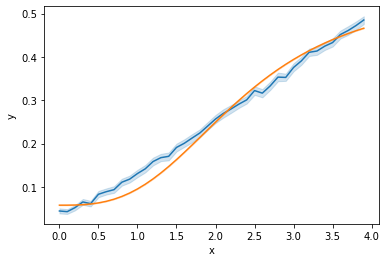

In [23]:
a5 = az.summary(trace_PL5_lin, var_names=['aC'])[['mean']]
b5 = az.summary(trace_PL5_lin, var_names=['bC'])[['mean']]
c5 = az.summary(trace_PL5_lin, var_names=['cC'])[['mean']]
d5 = az.summary(trace_PL5_lin, var_names=['dC'])[['mean']]
g5 = az.summary(trace_PL5_lin, var_names=['gC'])[['mean']]

df_C = pd.DataFrame({'a': np.mean(a5['mean']),
                     'b': np.mean(b5['mean']),
                     'c': np.mean(c5['mean']),
                     'd': np.mean(d5['mean']),
                     'g': np.mean(g5['mean']),
                     'x': cont_df.x})

df_C['y'] = df_C.d + (df_C.a-df_C.d)/(1+(df_C.x/df_C.c)**df_C.b)**df_C.g


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=df_C)

bad model good fit?